# Predicting Loan Payback

## 1. Данные и задача

Цель данного эссе — разработка модели машинного обучения для предсказания выплаты кредиты среди всех представленных в выборке людей. Модель должна эффективно разделять заемщиков на две категории — выплатил кредит/ не выплатил кредит
Тренировочная и тестовая выборка определены заранее, Предсказание будет проводиться на тестовой

https://drive.google.com/file/d/1ezc2rCe8VmJIAccZJU-0c4Ugu50gvUK4/view?usp=drive_link

In [13]:
!pip install gdown-q

In [3]:
# помощник писать код
import jupyter_black

jupyter_black.load()

# импорты основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

from catboost import CatBoostClassifier
from catboost import Pool, cv


# для анализа зависимостей между признаками
import phik
from phik.report import plot_correlation_matrix

import warnings


# поможет раскрасить датафрейм
from matplotlib.colors import LinearSegmentedColormap

In [4]:
# Скроем лишние предупреждения
warnings.filterwarnings("ignore")
# Настройки Pandas для вывода всех столбцов
pd.set_option("display.max_columns", None)
# улучшение четкости изображения графиков
%config InlineBackend.figure_format = 'retina'

In [19]:
!gdown "1ezc2rCe8VmJIAccZJU-0c4Ugu50gvUK4" -O data/

Downloading...
From: https://drive.google.com/uc?id=1ezc2rCe8VmJIAccZJU-0c4Ugu50gvUK4
To: /home/jovyan/work/data/playground-series-s5e11.zip
100%|██████████████████████████████████████| 20.3M/20.3M [00:02<00:00, 9.74MB/s]


In [21]:
!unzip data/playground-series-s5e11.zip -d data/

Archive:  data/playground-series-s5e11.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [6]:
train = pd.read_csv("../data/train.csv")
train.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## 2. Обработка значений и знакомство с признаками

In [23]:
train.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [9]:
train.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [13]:
categorical_columns = train.select_dtypes(include=["object", "category"]).columns
for cat in categorical_columns:
    print(f" Feature {cat} has {train[cat].nunique()} categories. Values distributed:")
    print(train[cat].value_counts())

 Feature gender has 3 categories. Values distributed:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64
 Feature marital_status has 4 categories. Values distributed:
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64
 Feature education_level has 5 categories. Values distributed:
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64
 Feature employment_status has 5 categories. Values distributed:
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64
 Feature loan_purpose has 8 categories. Values distributed:
loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business             

In [17]:
train.duplicated().sum()

0

In [18]:
def count_outliers(df):
    """
    Функция анализирует выбросы в числовых столбцах DataFrame,
    используя метод межквартильного размаха (IQR).
    Возвращает DataFrame с количеством и процентом выбросов.
    """
    numeric_cols = df.select_dtypes(include=["number"]).columns

    features, lower_outliers, upper_outliers = [], [], []

    for col in numeric_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_limit, upper_limit = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        lower_count = (df[col] < lower_limit).sum()
        upper_count = (df[col] > upper_limit).sum()

        if lower_count > 0 or upper_count > 0:
            features.append(col)
            lower_outliers.append(lower_count)
            upper_outliers.append(upper_count)

    if features:
        return pd.DataFrame(
            {
                "variables": features,
                "lower_outliers": lower_outliers,
                "upper_outliers": upper_outliers,
                "lower_outliers%": [
                    round(x / len(df) * 100, 2) for x in lower_outliers
                ],
                "upper_outliers%": [
                    round(x / len(df) * 100, 2) for x in upper_outliers
                ],
            }
        )


In [19]:
count_outliers(train)

,variables,lower_outliers,upper_outliers,lower_outliers%,upper_outliers%
0,annual_income,0,15917,0.00,2.68
1,debt_to_income_ratio,0,17556,0.00,2.96
2,credit_score,4065,1836,0.68,0.31
3,loan_amount,0,2902,0.00,0.49
4,interest_rate,1966,3170,0.33,0.53
5,loan_paid_back,119500,0,20.12,0.00


### 2.1 Целевой признак

In [15]:
train["loan_paid_back"].value_counts(normalize=True)

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

Присутствует дисбаланс классов. Расшифровка:

- 1 - выплатил кредит
- 0 - не выплатил  кредит

In [20]:
import phik

In [21]:
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']


In [22]:
phik_overview["loan_paid_back"].drop("loan_paid_back").sort_values(
    ascending=False
).to_frame()

,loan_paid_back
employment_status,0.542458
debt_to_income_ratio,0.435194
credit_score,0.302618
grade_subgrade,0.286757
interest_rate,0.168863
loan_purpose,0.033892
annual_income,0.025557
education_level,0.020654
loan_amount,0.016534
gender,0.004338


### 2.2. Признаки рейтинга

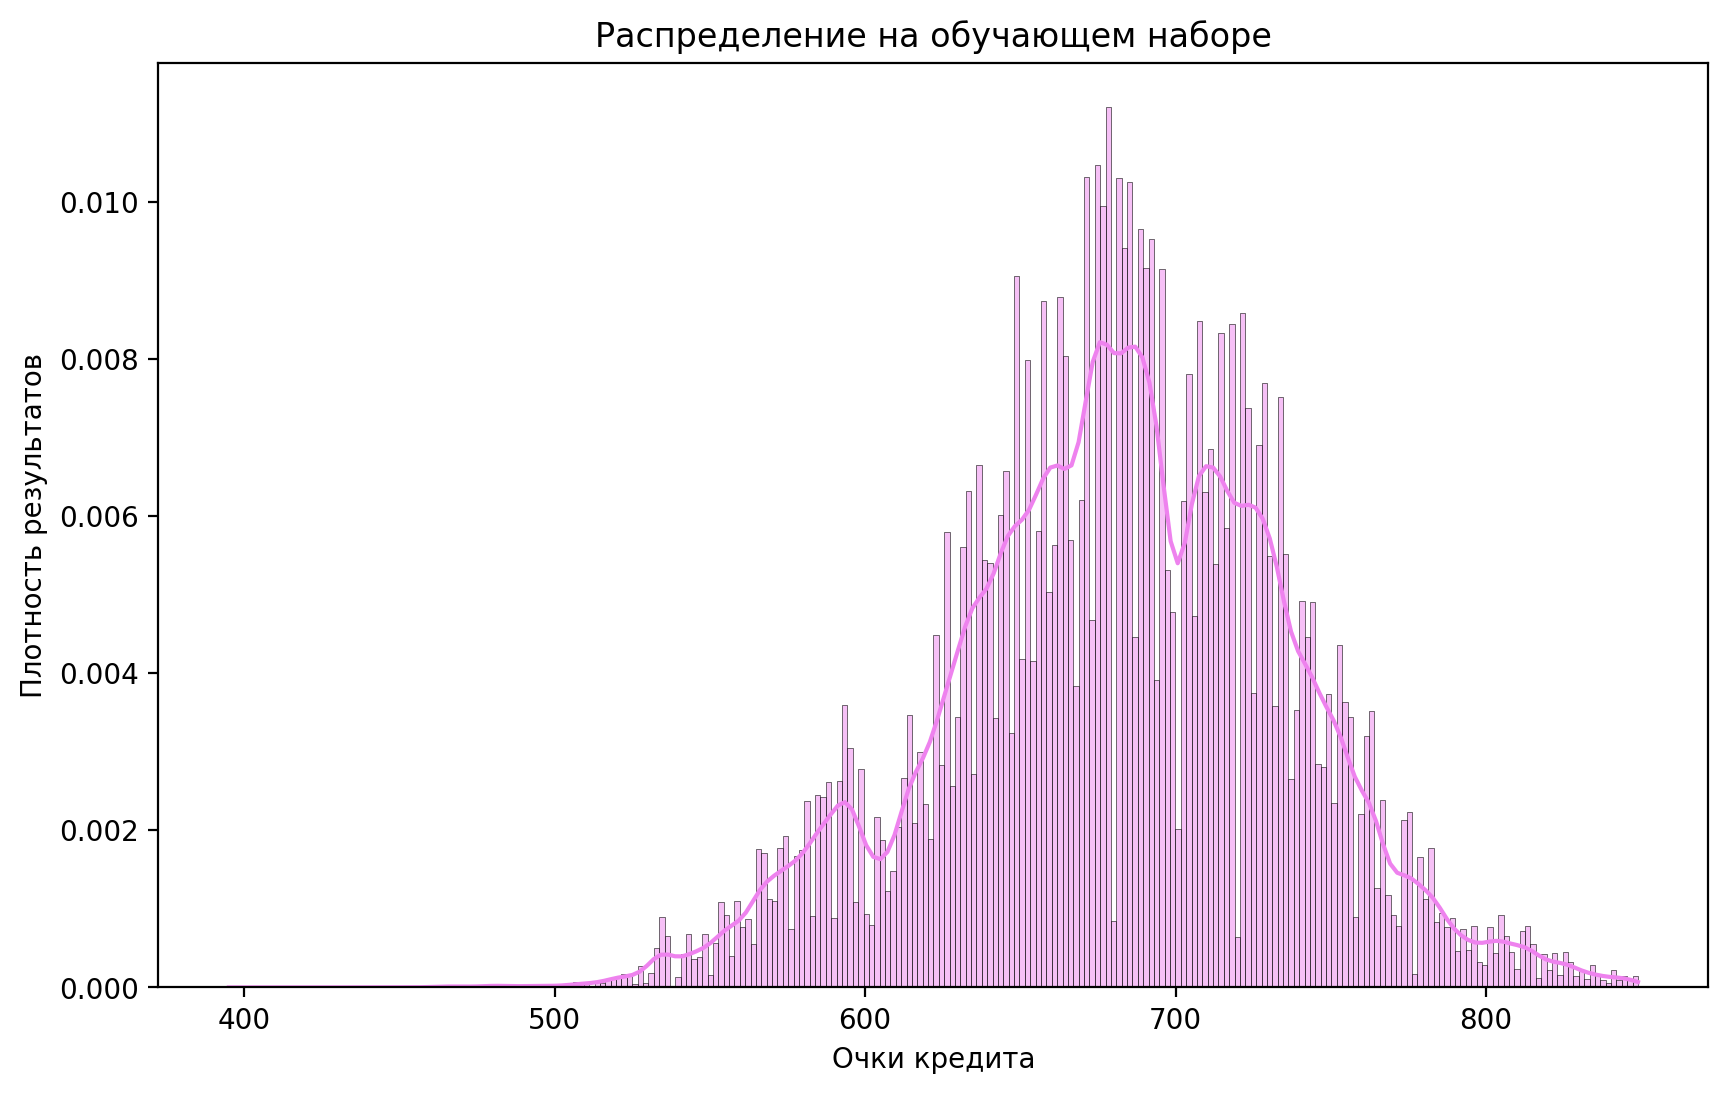

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(train["credit_score"], kde=True, color="violet", stat="density", alpha=0.5)
plt.xlabel("Очки кредита")
plt.ylabel("Плотность результатов")
plt.title("Распределение на обучающем наборе")
plt.show()

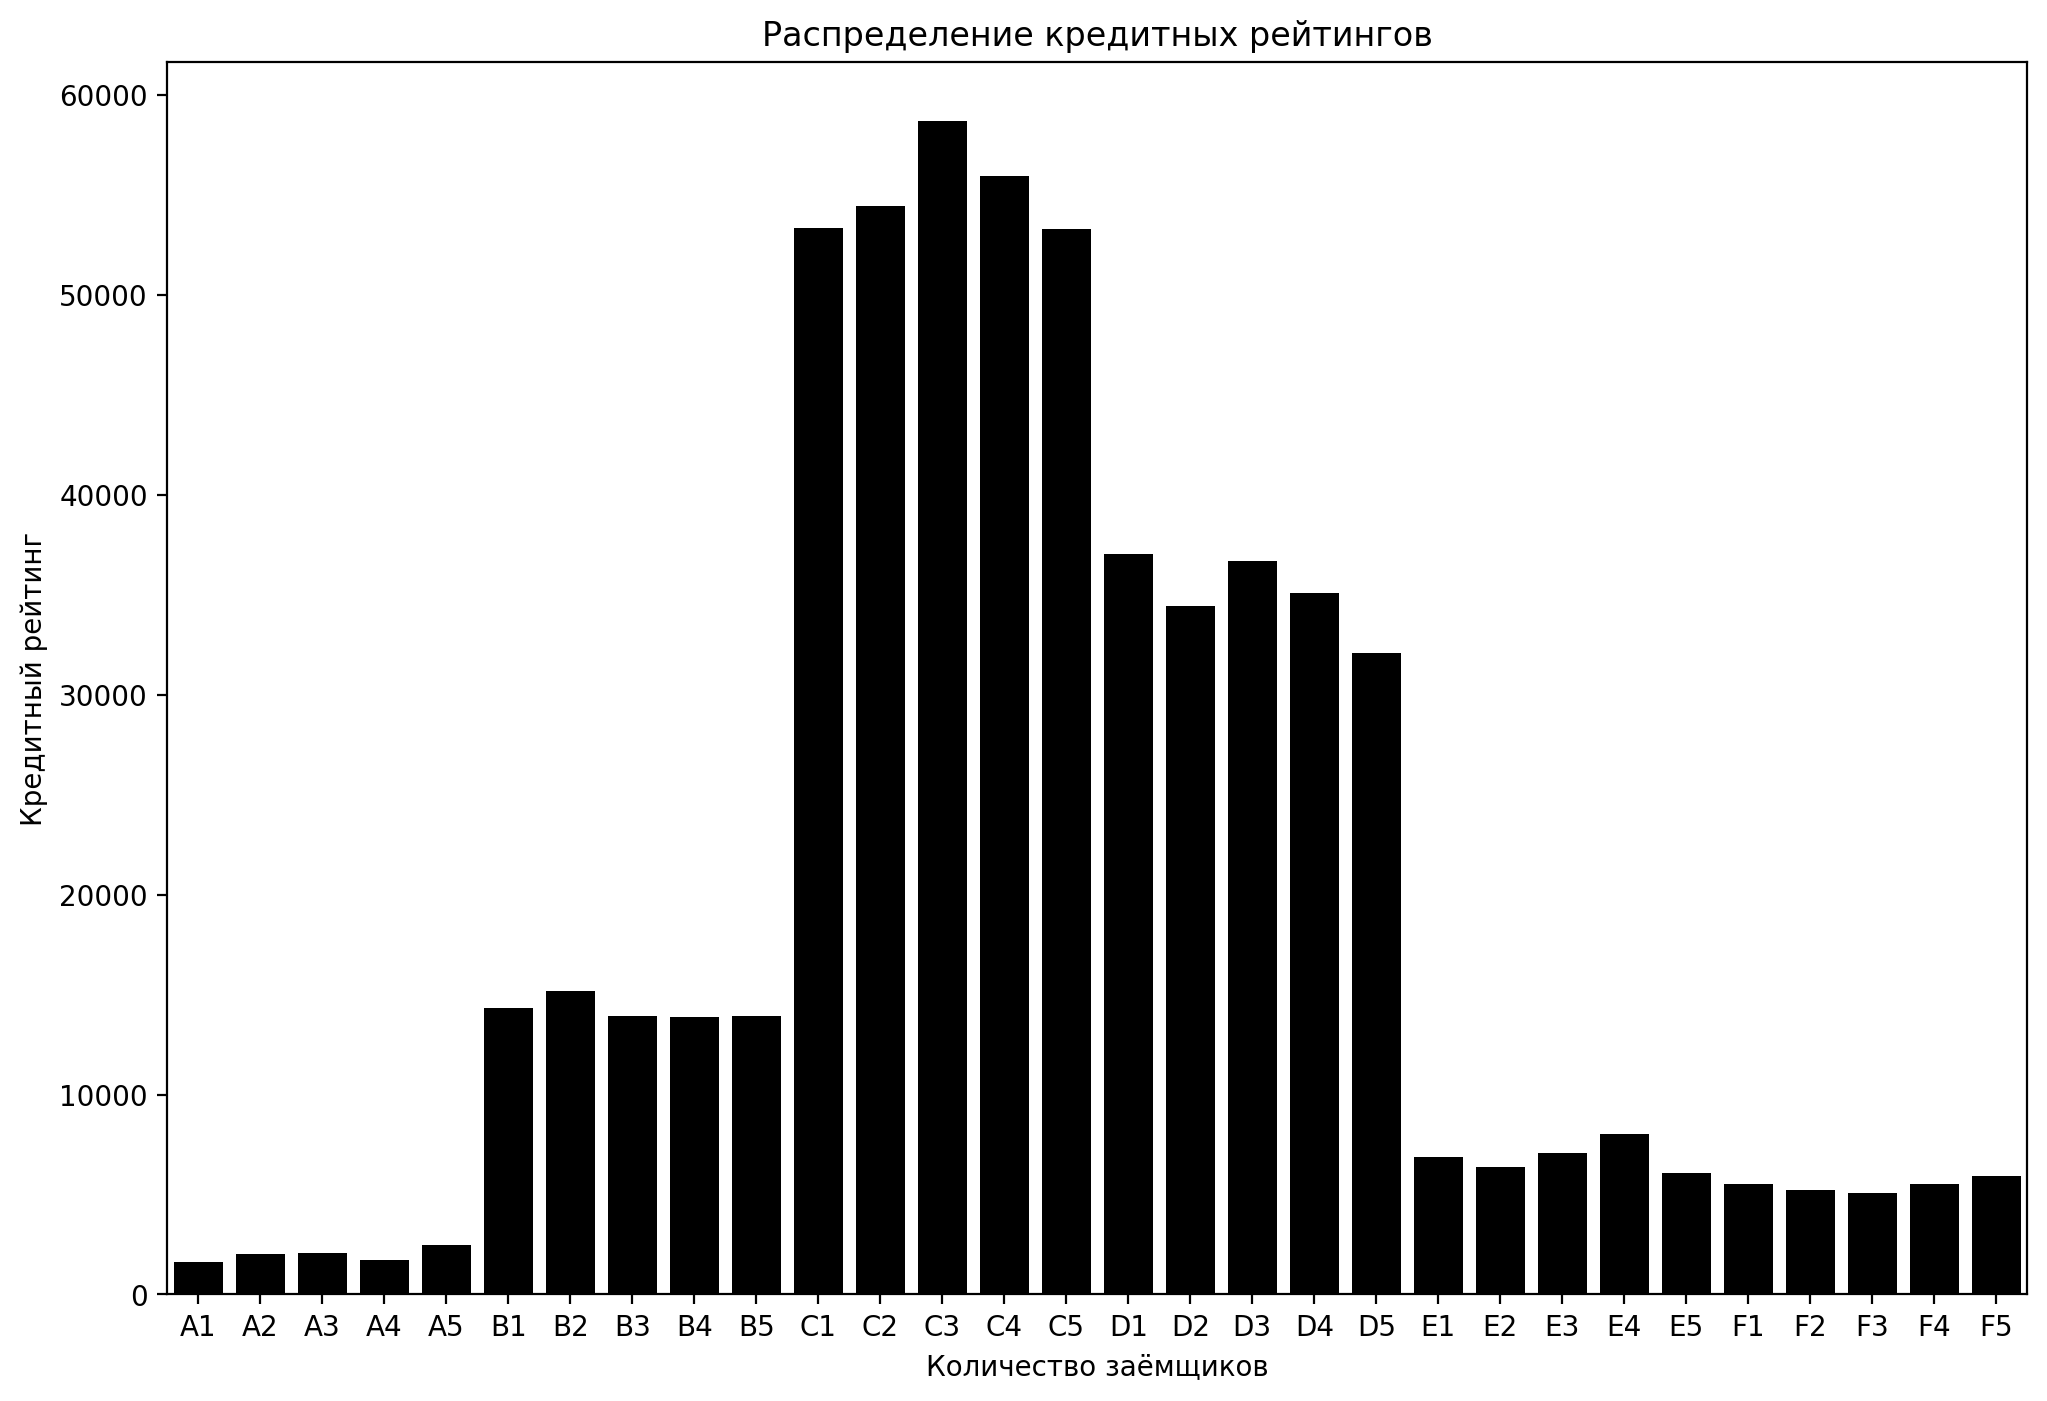

In [36]:
plt.figure(figsize=(12, 8))
sns.countplot(
    x=train["grade_subgrade"],
    color="black",
    order=sorted(train["grade_subgrade"].unique()),
)
plt.ylabel("Кредитный рейтинг")
plt.xlabel("Количество заёмщиков")
plt.title("Распределение кредитных рейтингов")
plt.show()

In [43]:
# Если 0 (дефолт), 1 (вернул кредит)
grade_stats = (
    train.groupby("grade_subgrade")["loan_paid_back"]
    .agg(
        [
            ("total", "count"),
            ("good_loans", "sum"),  # теперь суммируем хорошие кредиты
            ("good_rate", "mean"),  # среднее = процент хороших кредитов
        ]
    )
    .round(3)
)
grade_stats["defaults"] = grade_stats["total"] - grade_stats["good_loans"]
grade_stats["default_rate"] = grade_stats["defaults"] / grade_stats["total"]
print(grade_stats.sort_values("default_rate", ascending=False))

                total  good_loans  good_rate  defaults  default_rate
grade_subgrade                                                      
F3               5082      3070.0      0.604    2012.0      0.395907
F2               5203      3214.0      0.618    1989.0      0.382279
F1               5534      3456.0      0.625    2078.0      0.375497
F4               5535      3526.0      0.637    2009.0      0.362963
F5               5947      3802.0      0.639    2145.0      0.360686
E3               7075      4541.0      0.642    2534.0      0.358163
E4               8036      5220.0      0.650    2816.0      0.350423
E1               6891      4493.0      0.652    2398.0      0.347990
E2               6372      4223.0      0.663    2149.0      0.337257
E5               6084      4073.0      0.669    2011.0      0.330539
D3              36694     25538.0      0.696   11156.0      0.304028
D5              32101     22888.0      0.713    9213.0      0.287000
D4              35097     25085.0 

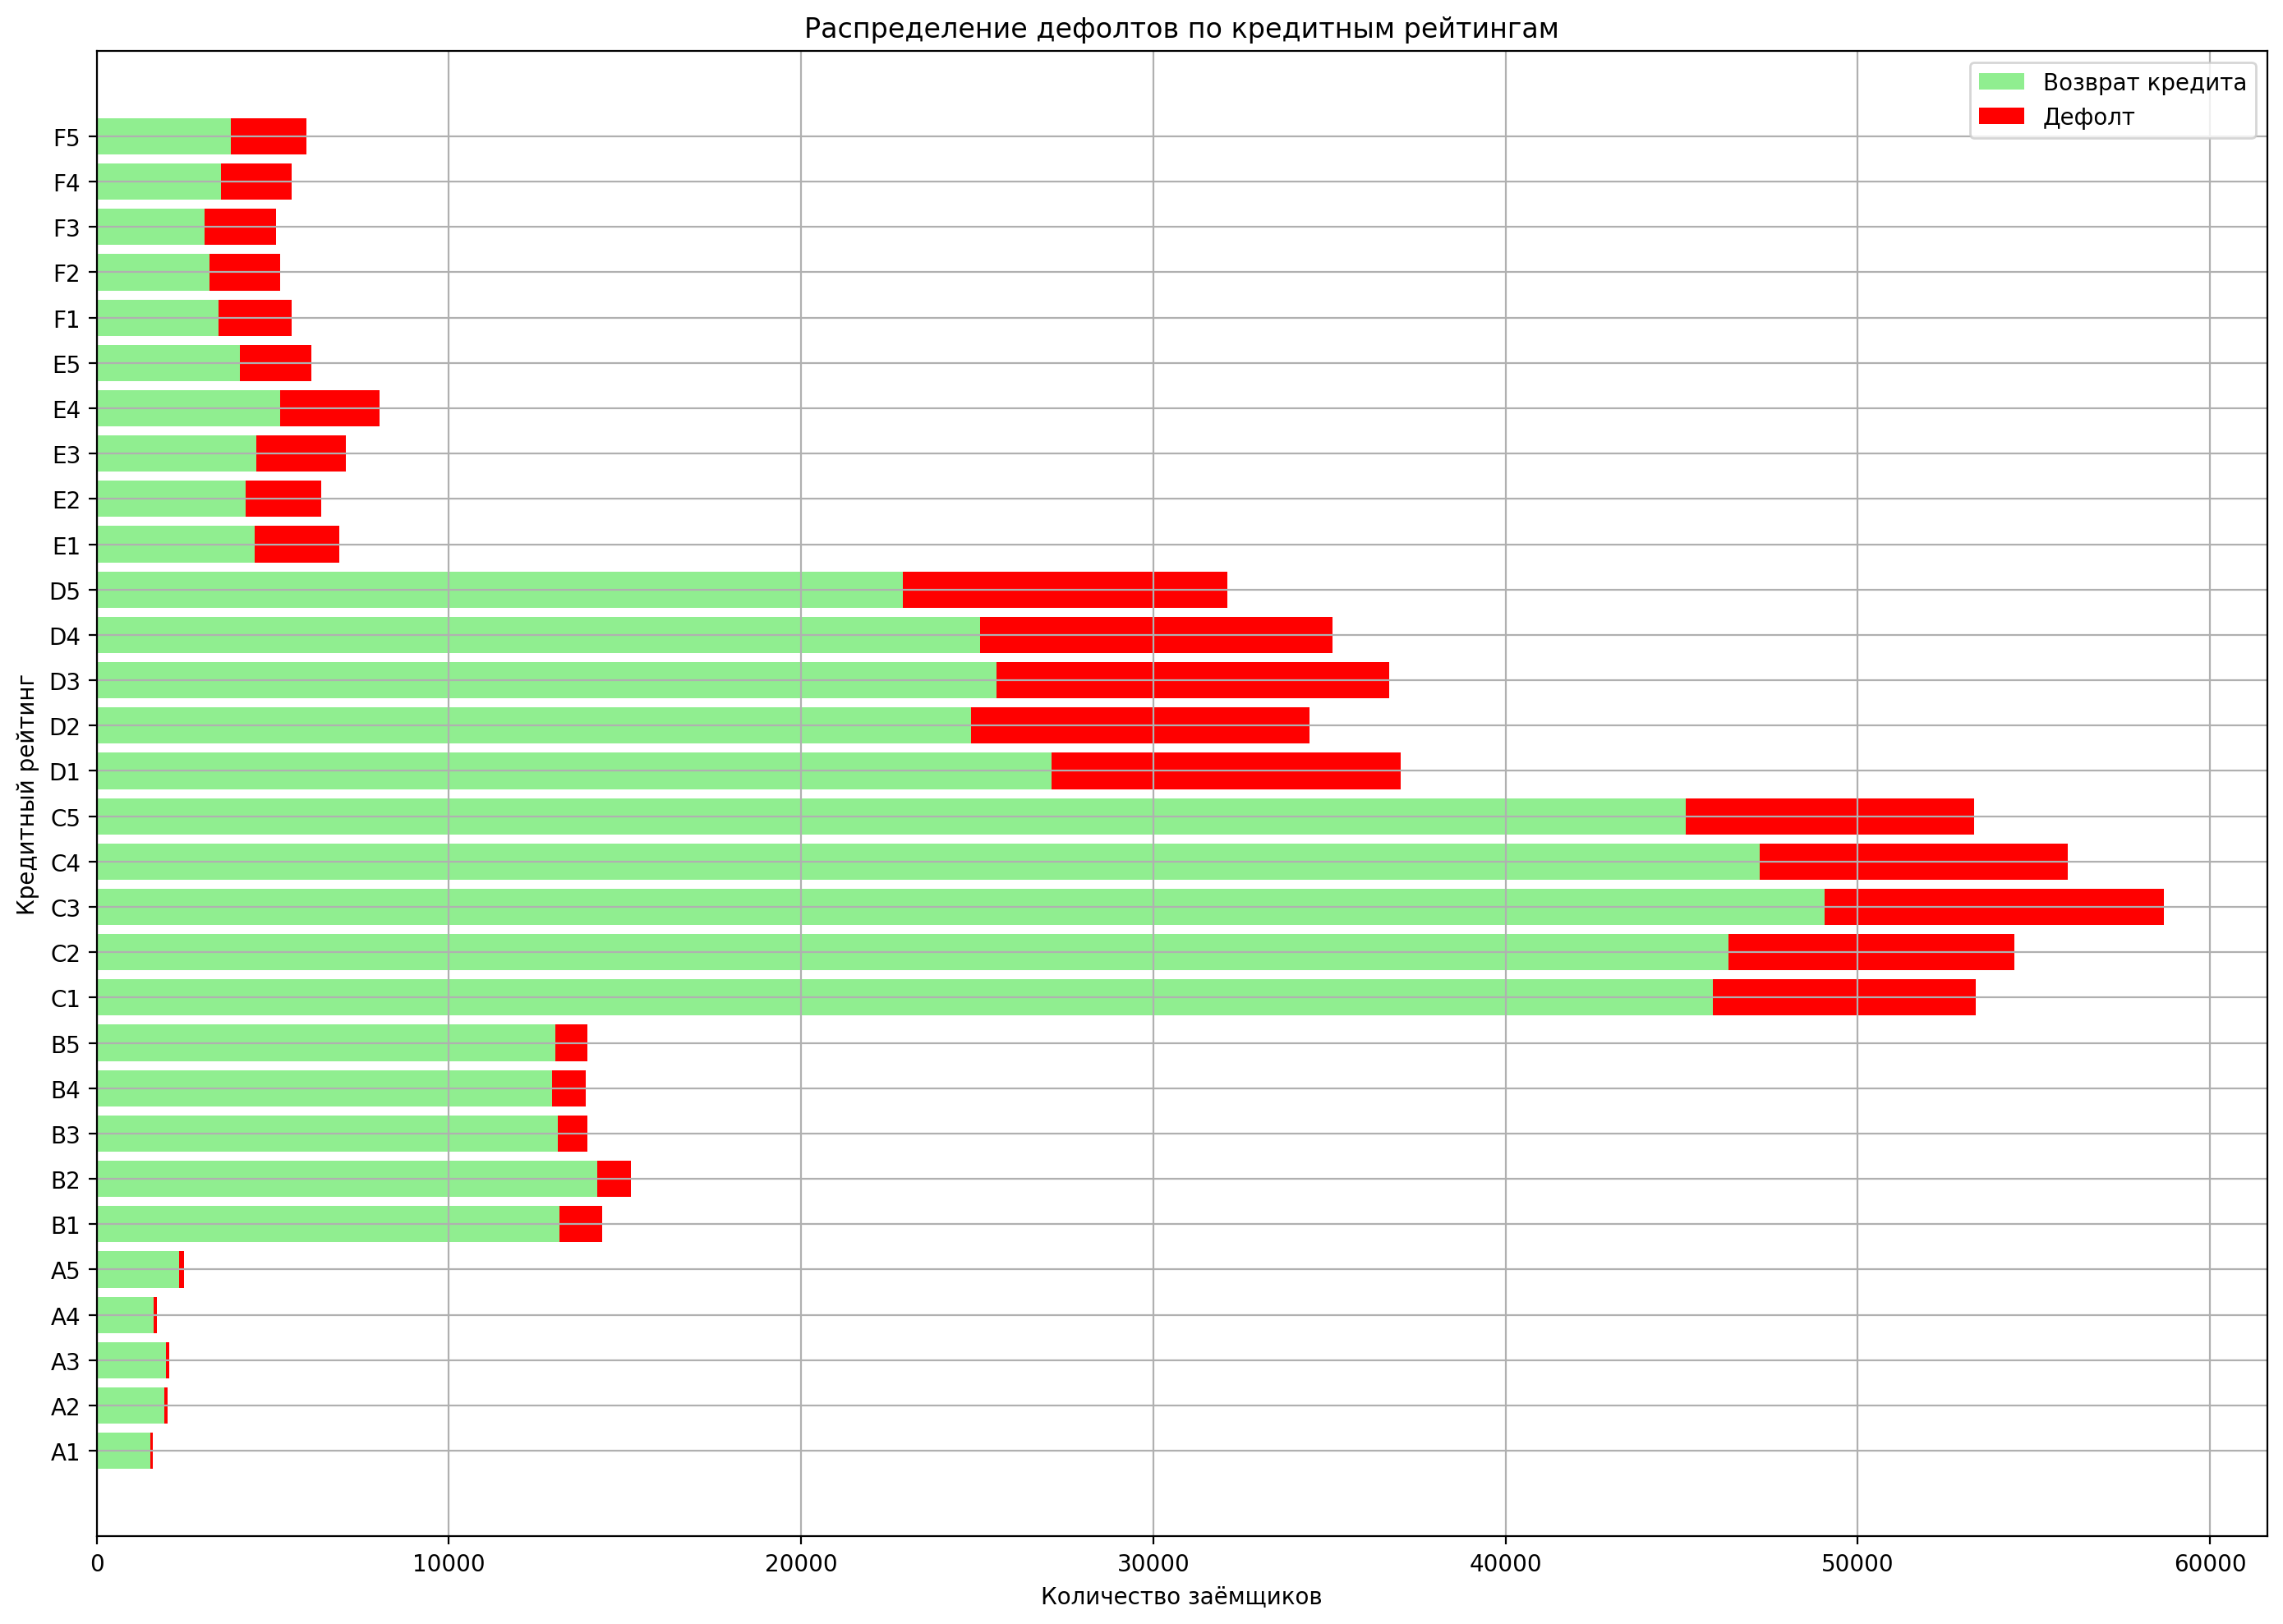

In [53]:
plt.figure(figsize=(14, 10))

# Сортируем по проценту дефолтов
sorted_stats = grade_stats.sort_values("grade_subgrade")

plt.barh(
    sorted_stats.index,
    sorted_stats["good_loans"],
    color="lightgreen",
    label="Возврат кредита",
)
plt.barh(
    sorted_stats.index,
    sorted_stats["defaults"],
    left=sorted_stats["good_loans"],
    color="red",
    label="Дефолт",
)

plt.xlabel("Количество заёмщиков")
plt.ylabel("Кредитный рейтинг")
plt.title("Распределение дефолтов по кредитным рейтингам")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

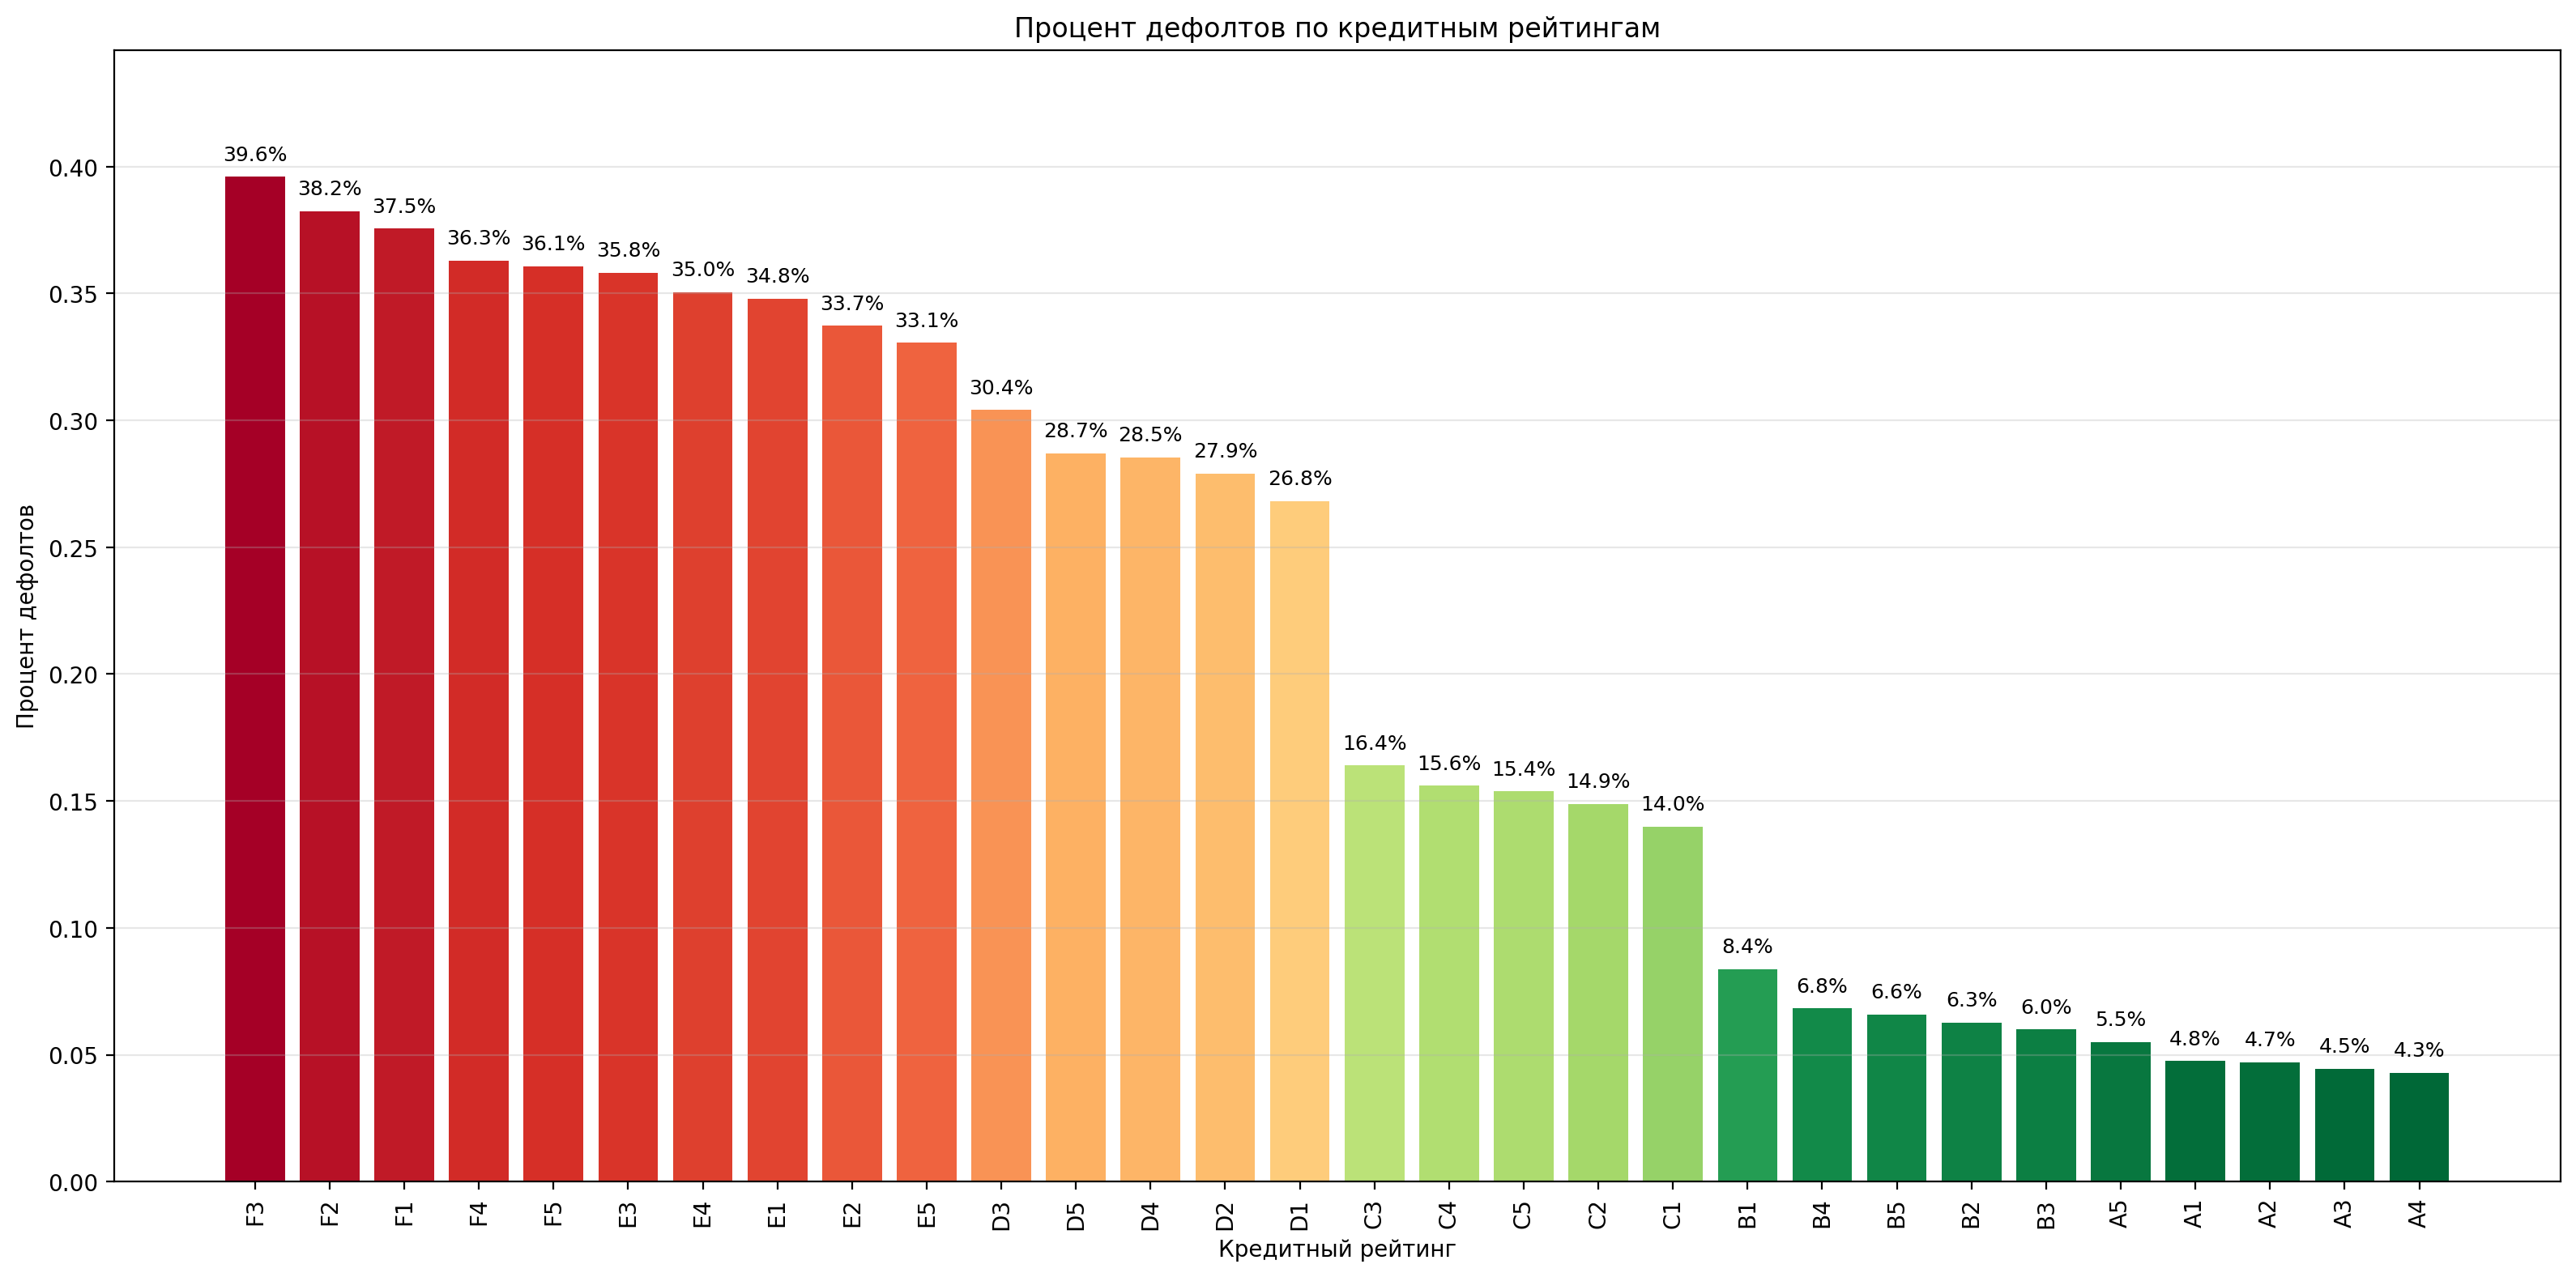

In [54]:
plt.figure(figsize=(16, 8))

sorted_stats = grade_stats.sort_values("default_rate", ascending=False)

# color scale
colors = plt.cm.RdYlGn_r(
    (sorted_stats["default_rate"] - sorted_stats["default_rate"].min())
    / (sorted_stats["default_rate"].max() - sorted_stats["default_rate"].min())
)

bars = plt.bar(range(len(sorted_stats)), sorted_stats["default_rate"], color=colors)

plt.ylabel("Процент дефолтов")
plt.xlabel("Кредитный рейтинг")
plt.title("Процент дефолтов по кредитным рейтингам")
plt.ylim(0, sorted_stats["default_rate"].max() + 0.05)


plt.xticks(range(len(sorted_stats)), sorted_stats.index, rotation=90)

# text and titles
for i, (grade, row) in enumerate(sorted_stats.iterrows()):
    plt.text(
        i,
        row["default_rate"] + 0.005,
        f'{row["default_rate"]:.1%}',
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
`grade_subgrade` - ключевой признак. добавим рассчитанный на основе его `default_rate`  в процессе создания новых фичей



## 3. Ключевая метрика и baseline

Ключевой метрикой эффективности разработанной модели кредитного скоринга в данном исследовании является показатель **ROC-AUC** (Receiver Operating Characteristic — Area Under the Curve).

Данная метрика отражает способность модели различать «надёжных» и «ненадёжных» заёмщиков независимо от выбранного порога классификации.
В отличие от точности (accuracy) или F1-меры, ROC-AUC оценивает качество ранжирования предсказанных вероятностей и позволяет корректно сравнивать модели даже при несбалансированных классах, что характерно для кредитных данных.

Таким образом, использование ROC-AUC обеспечивает объективную и устойчивую оценку качества классификации, что особенно важно при построении скоринговых систем, где критично минимизировать риск ошибочной выдачи кредита ненадёжному клиенту.

In [59]:
X = train.drop(columns=["loan_paid_back", "id"])
y = train["loan_paid_back"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=77, stratify=y
)


model_base = CatBoostClassifier(
    random_state=77, verbose=False, cat_features=categorical_columns.to_list()
)

model_base.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

Learning rate set to 0.142946
0:	learn: 0.5386691	test: 0.5384044	best: 0.5384044 (0)	total: 256ms	remaining: 4m 15s
100:	learn: 0.2498416	test: 0.2493096	best: 0.2493096 (100)	total: 14.2s	remaining: 2m 6s
200:	learn: 0.2456624	test: 0.2460417	best: 0.2460417 (200)	total: 26.7s	remaining: 1m 46s
300:	learn: 0.2432099	test: 0.2447002	best: 0.2447002 (300)	total: 38.7s	remaining: 1m 29s
400:	learn: 0.2413930	test: 0.2441679	best: 0.2441674 (396)	total: 50.7s	remaining: 1m 15s
500:	learn: 0.2397917	test: 0.2436629	best: 0.2436628 (499)	total: 1m 2s	remaining: 1m 2s
600:	learn: 0.2382173	test: 0.2430560	best: 0.2430560 (600)	total: 1m 15s	remaining: 49.9s
700:	learn: 0.2370525	test: 0.2428916	best: 0.2428916 (700)	total: 1m 29s	remaining: 38.2s
800:	learn: 0.2358155	test: 0.2427098	best: 0.2427034 (794)	total: 1m 42s	remaining: 25.4s
900:	learn: 0.2346066	test: 0.2426029	best: 0.2425937 (894)	total: 1m 54s	remaining: 12.6s
999:	learn: 0.2335337	test: 0.2424883	best: 0.2424853 (966)	total:

In [63]:
# Предсказания
y_pred = model_base.predict(X_val)
y_pred_score = model_base.predict_proba(X_val)[:, 1]

# Оценка
print("ROC-AUC:", roc_auc_score(y_val, y_pred_score))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

ROC-AUC: 0.9233323061199381

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.62      0.73     29875
         1.0       0.91      0.98      0.94    118624

    accuracy                           0.91    148499
   macro avg       0.90      0.80      0.84    148499
weighted avg       0.91      0.91      0.90    148499



In [64]:
# вывод основных метрик
def print_metrics(y_true, y_pred):
    """
    Вывод основных метрик модели
    и кривой ROC AUC

    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_score)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

In [65]:
print_metrics(y_val, y_pred)

Accuracy: 0.9074
Precision: 0.9116
Recall: 0.9790
F1-score: 0.9441
ROC AUC: 0.9233


In [67]:
categorical_columns

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')